In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from operator import attrgetter
import datetime as dt
import matplotlib.colors as mcolors
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [58]:
data=pd.read_csv('../input/ecommerce-uk-retailer/Ecommerce - UK Retailer.csv', encoding= 'unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Cleaning

In [59]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Since customer ID is absolutely needed and we don't have a reliable way to replace description, we'll drop the data points having NaN in both

In [61]:
data.dropna(subset=['CustomerID'], inplace=True)

In [62]:
data.dropna(subset=['Description'], inplace=True)

In [63]:
data.shape

(406829, 8)

## EDA

Questions to be answered

Q- What was the average quantity of items ordered overall?

Q- What is the average unit price of each item

In [64]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


Ans1- 12 approx.

Ans2- 3.5

From the table above, it can be seen that there are orders with negative quantity — most likely returns

Lets inspect the purchases with returns

In [65]:
# make a separate dataframe for 
dfReturns = data[data['Quantity'] < 0]
dfReturns.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [66]:
print(f'There are {len(dfReturns)} transactions for the returns')

There are 8905 transactions for the returns


In [67]:
# checking the countries that have most number of returns
dfReturns['Country'].value_counts()

United Kingdom        7533
Germany                453
EIRE                   247
France                 149
USA                    112
Australia               74
Spain                   48
Italy                   45
Belgium                 38
Japan                   37
Switzerland             35
Portugal                18
Malta                   15
Norway                  14
Poland                  11
Sweden                  11
Channel Islands         10
Finland                 10
Denmark                  9
Cyprus                   8
Netherlands              8
Singapore                7
Czech Republic           5
Austria                  3
Israel                   2
Saudi Arabia             1
European Community       1
Greece                   1
Name: Country, dtype: int64

In [68]:
#Q- top 10 products that are most returned?
dfReturns['Description'].value_counts().head(10)

REGENCY CAKESTAND 3 TIER              181
Manual                                175
POSTAGE                                97
JAM MAKING SET WITH JARS               86
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       73
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
Name: Description, dtype: int64

In [69]:
data=data[data['Quantity']>=0]
data.shape

(397924, 8)

By removing the returns, we create a bias in the dataset.

This way the initial order is taken into account even though in theory it was not realized and did not generate revenue as it was returned later on. 

Creating a 'Total Prices' Column for each purchase

In [70]:
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

Q- How many customers are repeat customers?

In [71]:
order_num = data.groupby(['CustomerID'])[['InvoiceNo']].nunique().apply(display)

CustomerID
12346.0     1
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4339, dtype: int64

As we can see, there are 4339 total customers. Let's see the number of repeat customers i.e. those who made >1 order

In [72]:
mul_orders = pd.DataFrame(data.groupby(['CustomerID'])[['InvoiceNo']].nunique())
mul_orders['InvoiceNo']=mul_orders['InvoiceNo'].astype(int)
mul_orders=mul_orders[mul_orders['InvoiceNo']>1]
len(mul_orders)

2845

As we can see, 2845 customers made a repeat purchase. That means, around 65% customers were retained.

Q- Who are the most frequent shoppers?


In [73]:
data["CustomerID"].value_counts().head()


17841.0    7847
14911.0    5677
14096.0    5111
12748.0    4596
14606.0    2700
Name: CustomerID, dtype: int64

Q-Number of unique products?

In [74]:
data["StockCode"].nunique()

3665

Q-Top 5 products bought?

In [75]:
data["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1724
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1397
Name: Description, dtype: int64

Q-Which countries placed the most orders?

In [76]:
data['Country'].value_counts().head()

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: Country, dtype: int64

Q-Which countries spent the most?

In [77]:

data.groupby("Country").agg({"TotalPrice": "sum"}).sort_values(by = "TotalPrice", ascending = False).head()

,TotalPrice
Country,
United Kingdom,7308391.554
Netherlands,285446.340
EIRE,265545.900
Germany,228867.140
France,209024.050


Q-Customers who spent the most?


In [78]:

data.groupby("InvoiceNo").agg({"TotalPrice": "sum"}).sort_values(by = "TotalPrice", ascending = False).head()

,TotalPrice
InvoiceNo,
581483,168469.60
541431,77183.60
556444,38970.00
567423,31698.16
556917,22775.93


Q-Percentage of consumers ordered more than once?

Finding Invoice month & year from invoice date

In [79]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
  
# Create the invoicemonth period column
data['InvoiceMonthYear'] = data['InvoiceDate'].apply(get_month)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonthYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


Q- What was the time for which each customer was retained? What is the trend of retention?

In [80]:
grouping = data.groupby('CustomerID')['InvoiceMonthYear']
#finding and assigning earliest date of joining for each customer, here cohort refers to the time of joining
data['CohortMonthYear'] = grouping.transform('min')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonthYear,CohortMonthYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01


Finding the time for which each customer stayed with the company(in months)

In [81]:
data['InvoiceMonthYear']=pd.to_datetime(data['InvoiceMonthYear'])
data['CohortMonthYear']=pd.to_datetime(data['CohortMonthYear'])

  
invoice_year, invoice_month = data['InvoiceMonthYear'].dt.year,data['InvoiceMonthYear'].dt.month
cohort_year, cohort_month = data['CohortMonthYear'].dt.year,data['CohortMonthYear'].dt.month
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
data['MonthsRetained'] = years_diff * 12 + months_diff + 1
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonthYear,CohortMonthYear,MonthsRetained
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


Plotting the results

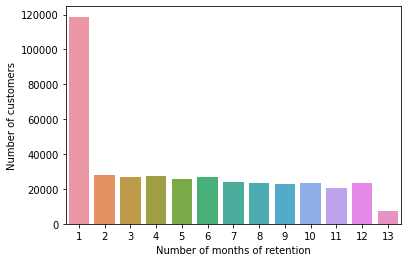

In [82]:
sns.countplot(data['MonthsRetained'])
plt.xlabel("Number of months of retention")
plt.ylabel("Number of customers")
plt.show()

As we can see, a large chunk of customers stayed only for 1 month. 

We can see that there was a significant decrease in the number of customers using the product in the next month. and after that month, there is steady flow of customers for the rest of the year except that next year where less loyal customers were present. 

This could be many reasons:
1. No end of the year sales or discounts.
2. No seasonal or festival offers
(This may vary from country to country)
3. No new updates on products or interface of the store.

Going deeper, let's see the retention rate of customers cohortwise.

In [83]:
group = data.groupby(['CohortMonthYear', 'MonthsRetained'])
cohorts = group['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohorts.pivot(index='CohortMonthYear', columns='MonthsRetained', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
retention_percent = cohort_counts.divide(cohort_sizes, axis=0)*100

In [84]:
month_list = retention_percent.reset_index()['CohortMonthYear']

def get_month_name(x):
   return dt.datetime.strftime(x, '%b-%y')
  
month_list = month_list.apply(get_month_name)

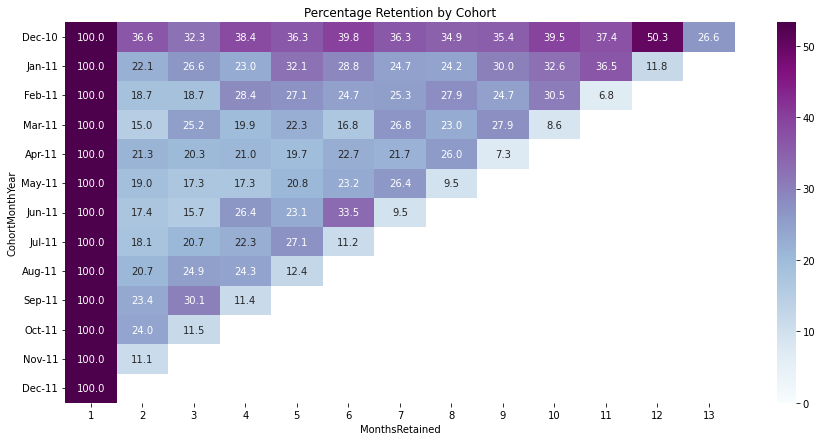

In [85]:

plt.figure(figsize=(15,7))
plt.title('Percentage Retention by Cohort')
sns.heatmap(data=retention_percent,annot = True,vmin = 0.0, cmap="BuPu",vmax = list(retention_percent.max().sort_values(ascending = False))[1]+3,fmt = '.1f',yticklabels=month_list)
plt.show()

As we can see, retention of customers shows a general decreasing trend as the months go by.

Based on the cohort analysis graph of Percentage Retention of cohorts, we deduce following observations:

1. Customers who purchased first time in the month of december 2010, there was significant decline in customers purchasing in the next 11 months but at the end of the year the customers came back to purchase the products in the store by a huge margin - This is due to end of the year sales or discounts done to attract new and old customers to purchase which is good but a temporary solution to increase revenue 

2. During May to August 2011, we can see that the retention rate increases after a lag. For most of the regions, the retentiaon rate increases after 8 to 10 periods but later end of year declined. The increase could be the email marketing done with the old customers that allowed them to return purchasing products but later at the end, less customers returned. due to no or less communication with the store. The store should initiate discount vaouchers for customers, who do purchases each month. This way, they will be able to increase their revenue.



Q- What is the average spending behaviour of each cohort

In [86]:
gp=group['UnitPrice'].mean().reset_index()
average_price = gp.pivot(index='CohortMonthYear', columns='MonthsRetained', values='UnitPrice')
average_price.index = average_price.index.date

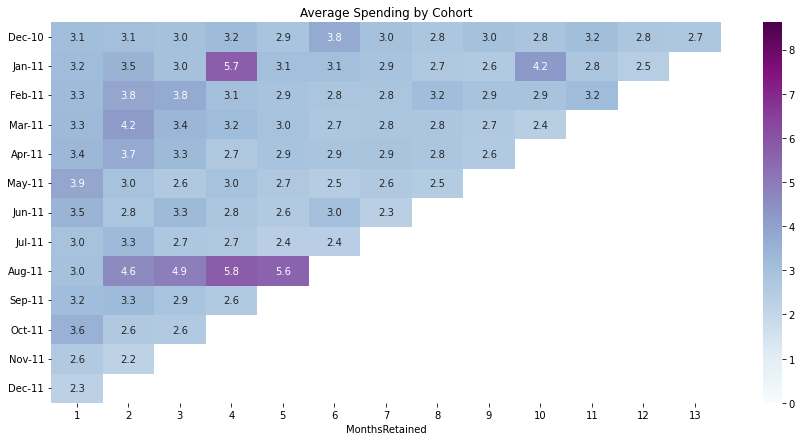

In [87]:
plt.figure(figsize=(15,7))
sns.heatmap(data = average_price,annot=True,vmin = 0.0, cmap="BuPu",vmax = list(average_price.max().sort_values(ascending = False))[1]+3,fmt = '.1f',yticklabels=month_list)
plt.title('Average Spending by Cohort')
plt.show()

Average spending of each cohort by month remains rather stable, with some exceptions.

Q - What is the average quantity by each monthly cohort?

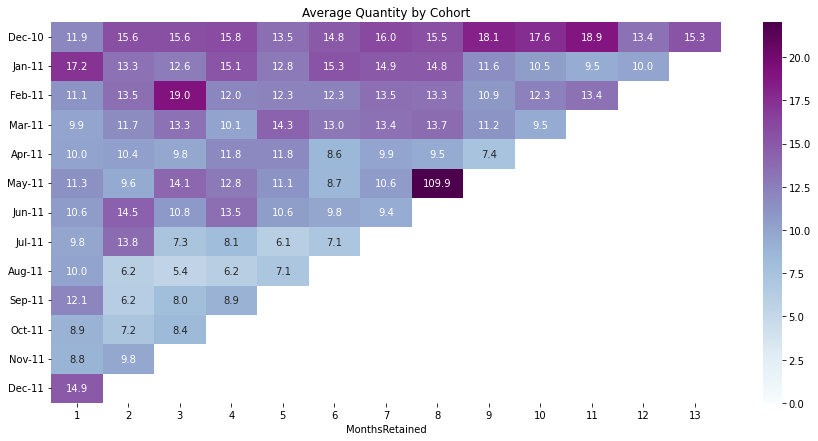

In [88]:
gp=group['Quantity'].mean().reset_index()
average_quantity = gp.pivot(index='CohortMonthYear', columns='MonthsRetained', values='Quantity')
average_quantity.index = average_quantity.index.date

plt.figure(figsize=(15,7))
sns.heatmap(data = average_quantity,annot=True,vmin = 0.0, cmap="BuPu",vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,fmt = '.1f',yticklabels=month_list)
plt.title('Average Quantity by Cohort')
plt.show()

Based on the graph above, we notice that cohort on May 2011, there is an significant increase in quantity of sales at the end of the year. This may be due to the store's clearance sale that allowed them to sell the products at cheap rate to clear the stock. But By looking at the cohort retention chart in the same may 2011 cohort, it didnt improve the number of new customers arriving to the store. It may have increased the revenue but compromised the quality of the product which in turn had negative feedback from the loyal customers.

What is the trend of customer retention in each country?

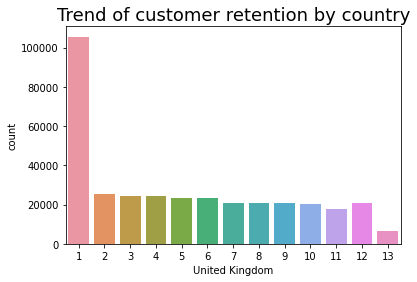

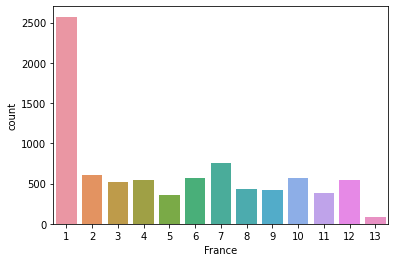

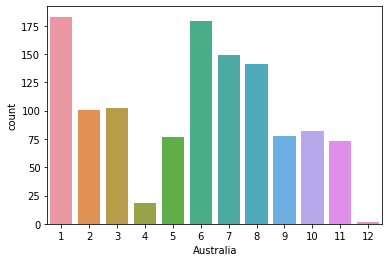

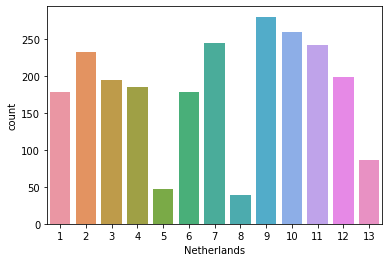

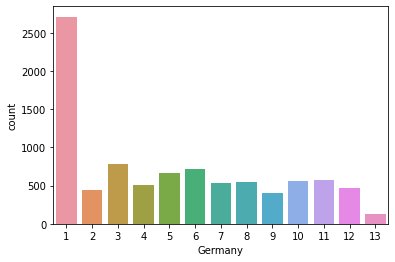

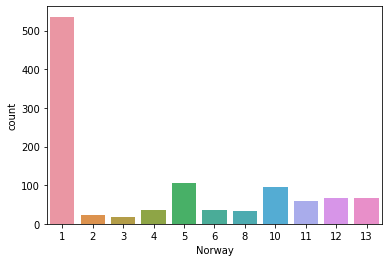

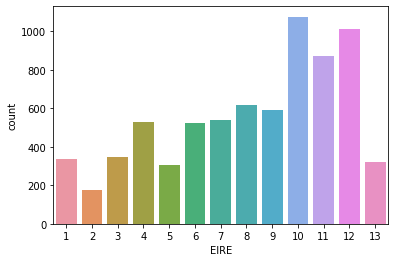

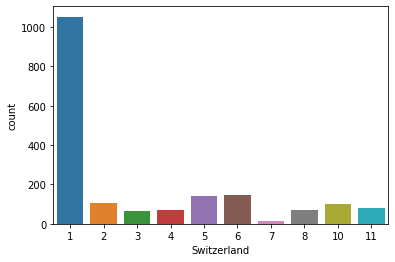

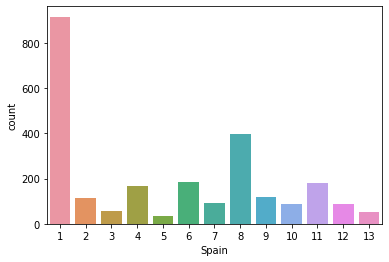

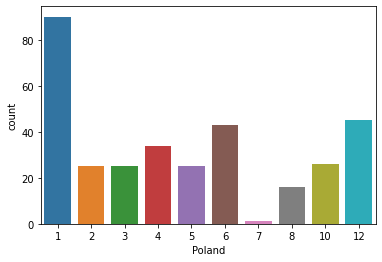

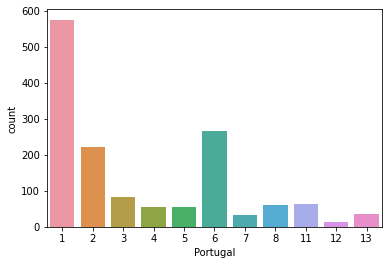

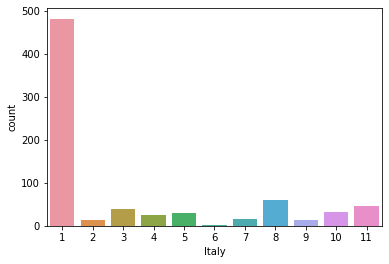

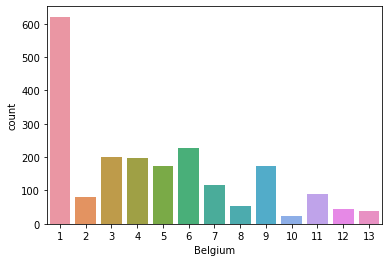

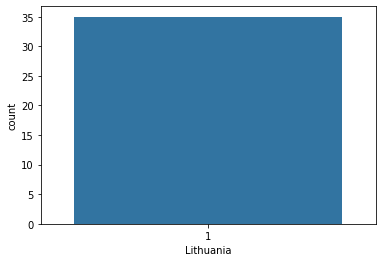

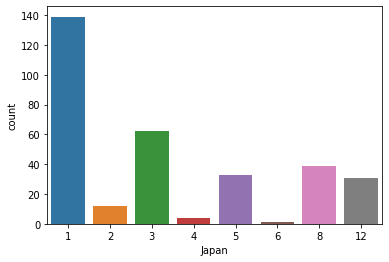

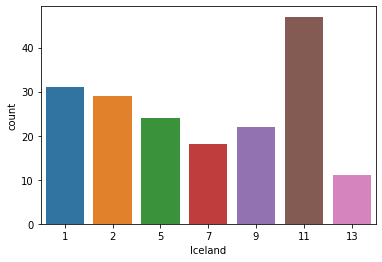

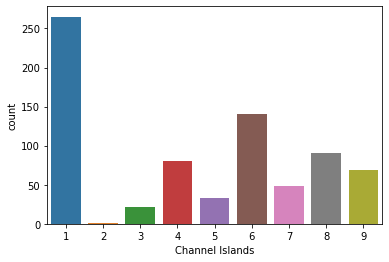

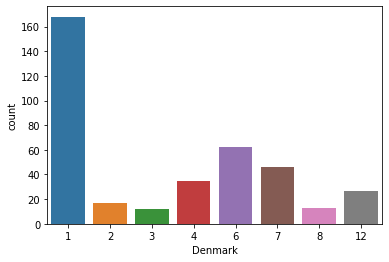

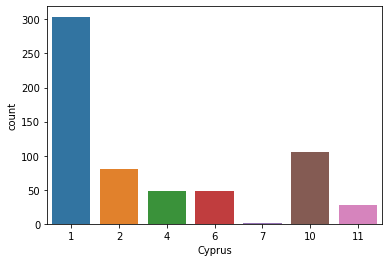

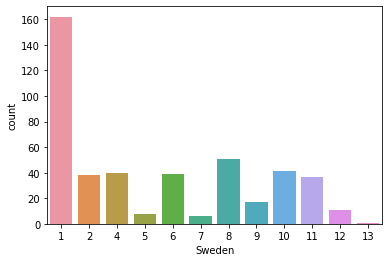

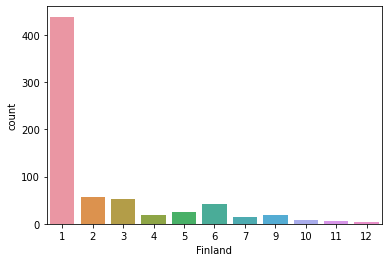

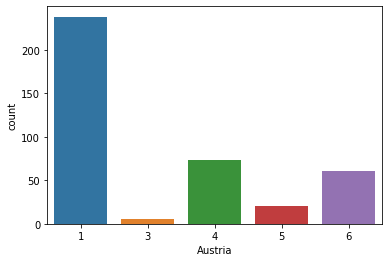

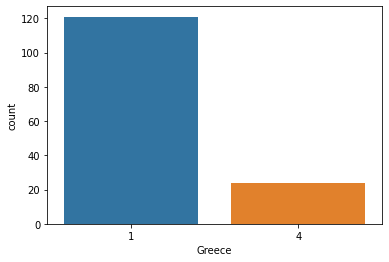

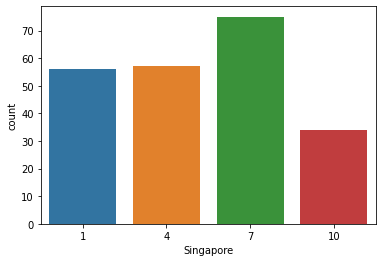

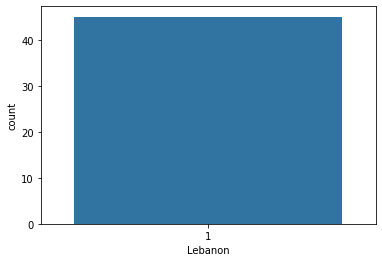

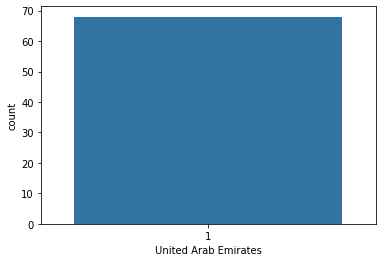

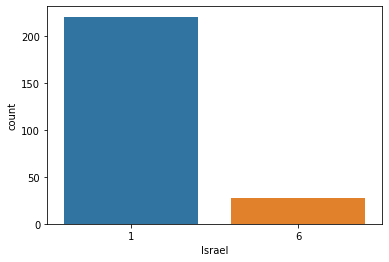

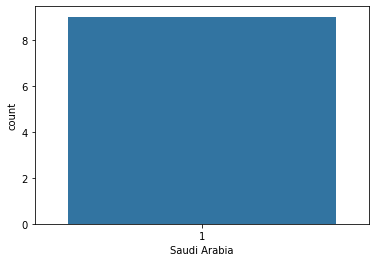

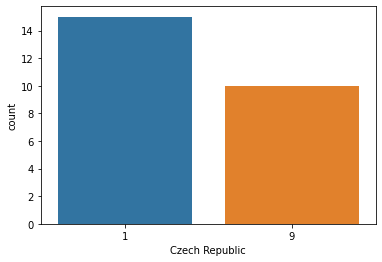

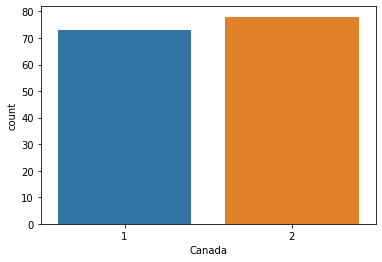

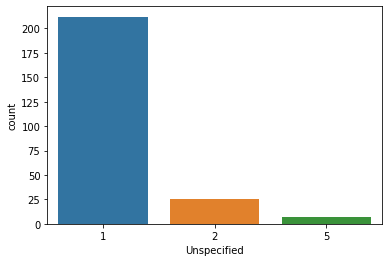

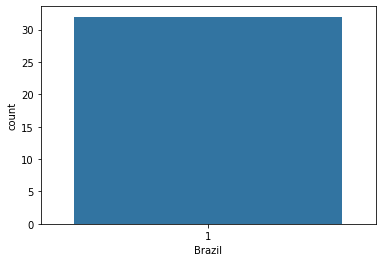

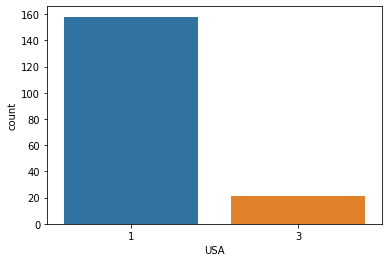

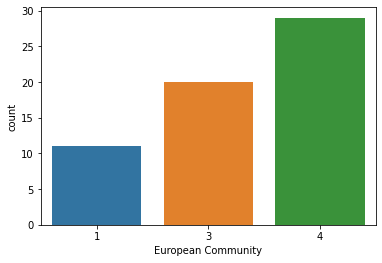

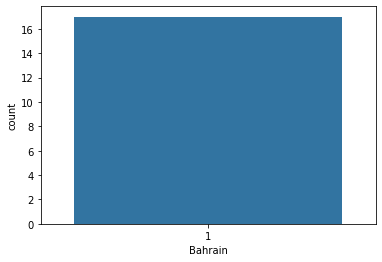

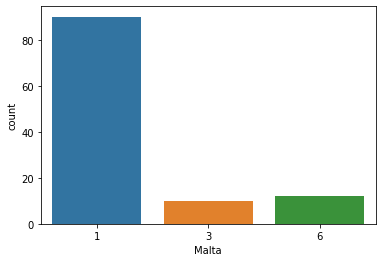

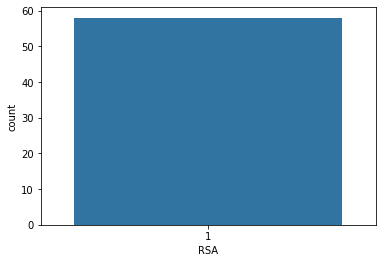

In [89]:

plt.title("Trend of customer retention by country", fontsize=18, y=1)

for x in data['Country'].unique():
  data2=data[data['Country']==x]
  sns.countplot(data2['MonthsRetained'])
  plt.xlabel(x)
  plt.show()

In a large number of countries, we observe that retention is much more compared to UK but it is overriden by the low number of customers. Hence one solution would be to focus on increasing the reach of the company in foreign markets, especially those with low attrition rates, like Netherlands,Iceland,EIRE,Australia etc.

In addition to that, there must be flexibility of having language compatibility in the online store so that customer in different countries can establish a long term relationship with the store and conduct purchases with ease. Increasing the retention rate at the same time.

Key Observations:

1. In EIRE, no cohort is formed after December, 2010. This is a major point of concern. EIRE is their fourth largest potential market. Additionally, the retention rate of EIRE is better than its counter parts reaching upto 100% after certain periods. This hints that the customer base of EIRE is very loyal. The ecommerce store should do campaigns in EIRE to further tap this potential market and gain more loyal customers, in turn, increases revenue.

2. UK market is their largest customer base. But, most of the returns are also from UK. This is an alarming situation. The store should focus more on the needs and the wants of UK  customer base to increase the revenue even further.



### Countrywise retention matrix analysis
As we observed, people from were many countries were customers. Let's look at the situation countrywise.

### UK

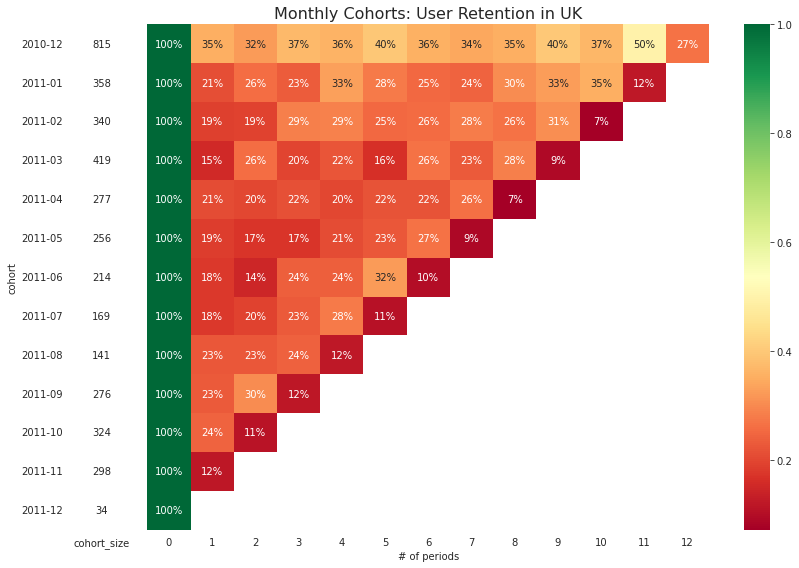

In [90]:
# filtering records for UK only
dfUK = data[data['Country']=='United Kingdom']

# drop irrelevant columns and duplicate records
dfUK = dfUK[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfUK['order_month'] = dfUK['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfUK['cohort'] = dfUK.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfUK.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in UK', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Text(0.5, 1.0, 'retention rate in the UK')

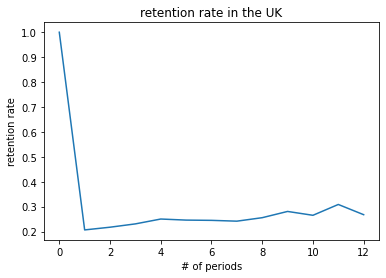

In [91]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in the UK')

### Germany

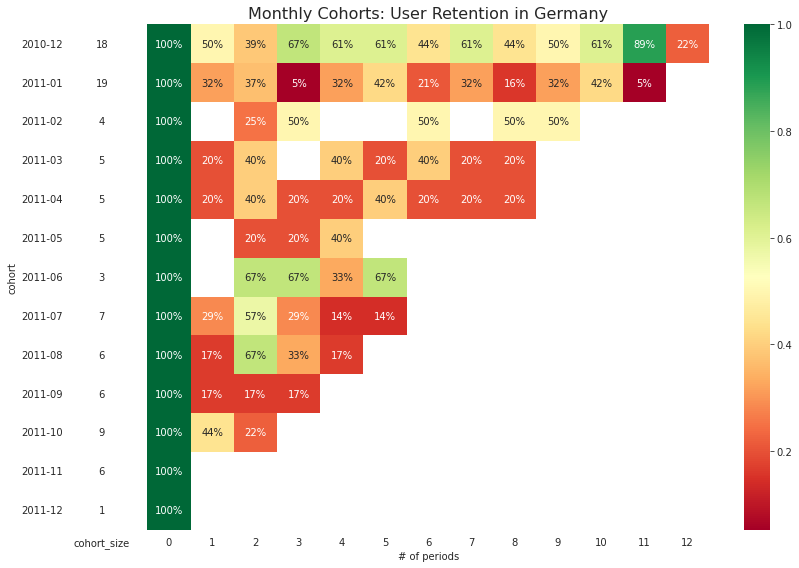

In [92]:
# filtering records for Germany only
dfGermany = data[data['Country']=='Germany']

# drop irrelevant columns and duplicate records
dfGermany = dfGermany[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfGermany['order_month'] = dfGermany['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfGermany['cohort'] = dfGermany.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfGermany.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Germany', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Text(0.5, 1.0, 'retention rate in Germany')

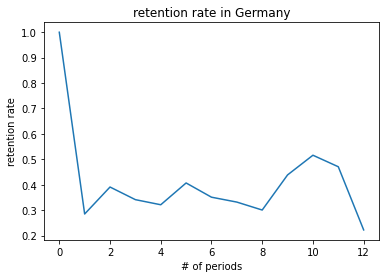

In [93]:
# plot retention rate
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in Germany')

### Australia

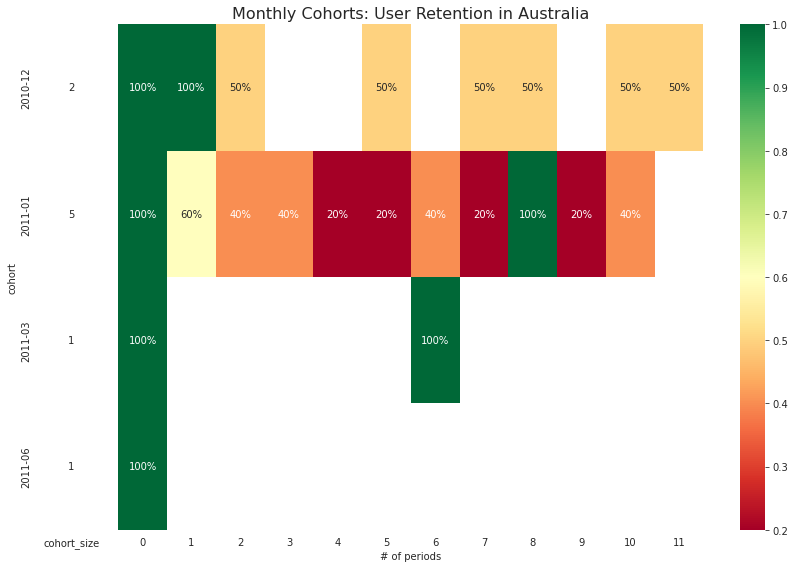

In [94]:
# filtering records for Australia only
dfAustralia = data[data['Country']=='Australia']

# drop irrelevant columns and duplicate records
dfAustralia = dfAustralia[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfAustralia['order_month'] = dfAustralia['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfAustralia['cohort'] = dfAustralia.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfAustralia.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Australia', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Text(0.5, 1.0, 'retention rate in Australia')

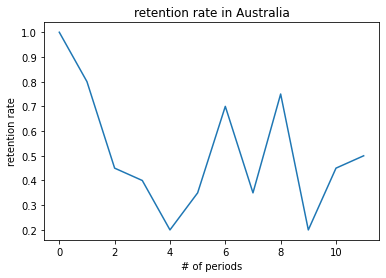

In [95]:
# plot retention rate
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in Australia')

### Netherlands

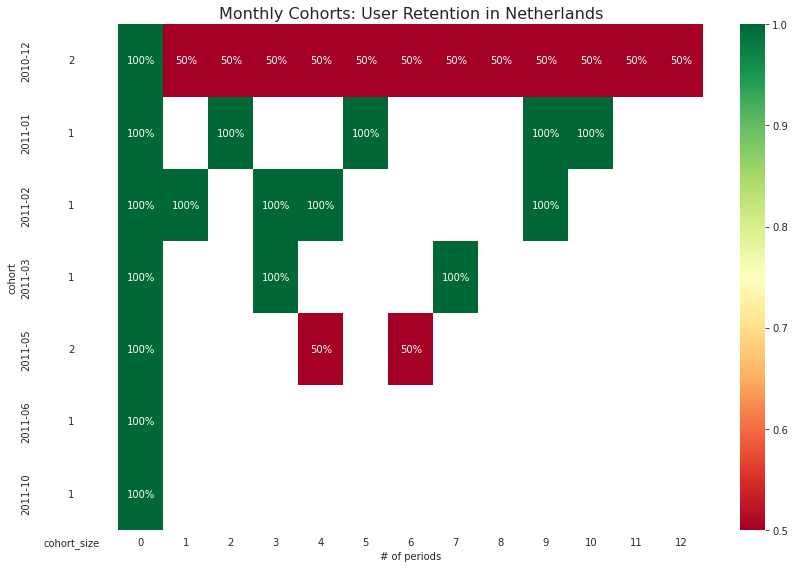

In [96]:
# filtering records for Netherlands only
dfNetherlands = data[data['Country']=='Netherlands']

# drop irrelevant columns and duplicate records
dfNetherlands = dfNetherlands[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfNetherlands['order_month'] = dfNetherlands['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfNetherlands['cohort'] = dfNetherlands.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfNetherlands.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Netherlands', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Text(0.5, 1.0, 'retention rate in the Netherlands')

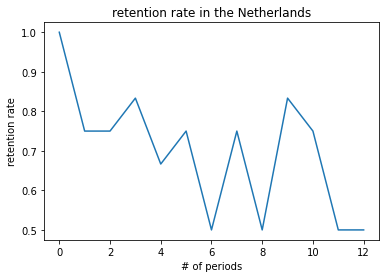

In [97]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in the Netherlands')

### Iceland

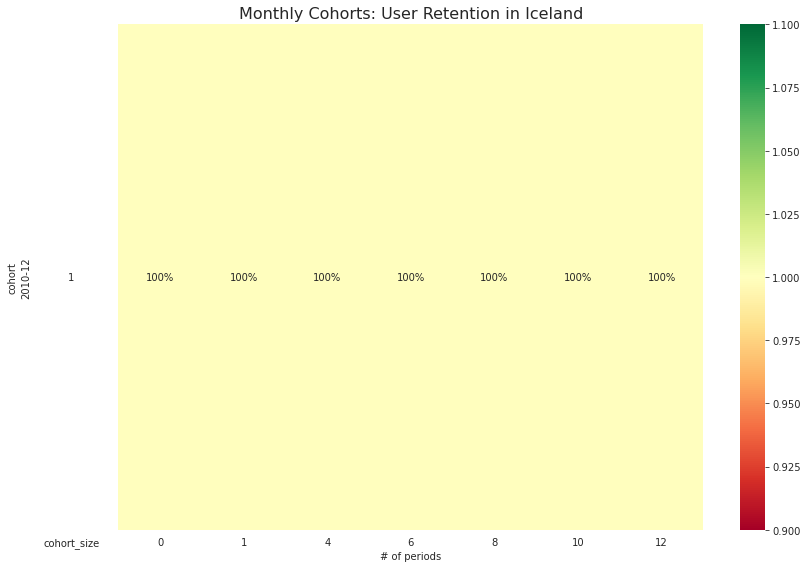

In [98]:
# filtering records for Iceland only
dfIceland = data[data['Country']=='Iceland']

# drop irrelevant columns and duplicate records
dfIceland = dfIceland[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfIceland['order_month'] = dfIceland['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfIceland['cohort'] = dfIceland.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfIceland.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Iceland', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Text(0.5, 1.0, 'retention rate in Iceland')

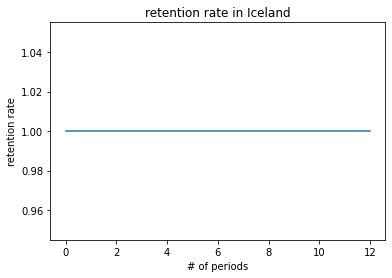

In [99]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in Iceland')

### EIRE

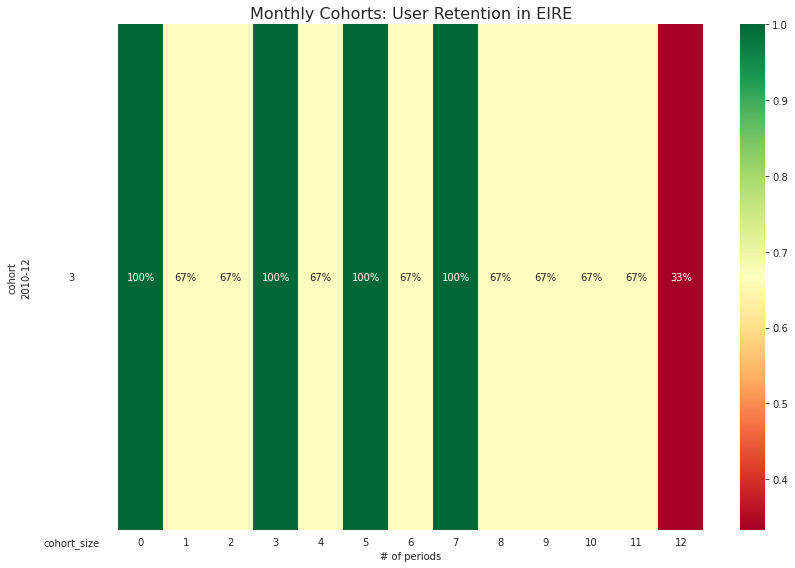

In [100]:
# filtering records for EIRE only
dfEIRE = data[data['Country']=='EIRE']

# drop irrelevant columns and duplicate records
dfEIRE = dfEIRE[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfEIRE['order_month'] = dfEIRE['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfEIRE['cohort'] = dfEIRE.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfEIRE.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in EIRE', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Text(0.5, 1.0, 'retention rate in EIRE')

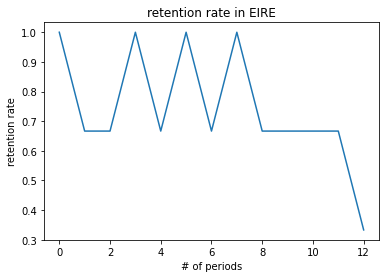

In [101]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in EIRE')

## Customer Segmentation using RFM modeling

Before we can proceed, we need a benchmark date from where we can calculate recency i.e. date of analysis. 
Recency=Analysis Date- Transaction date

for the purpose of simplifaction we can assume that analysis commenced 1 day after the last transaction.

In [102]:
last_txn_date= data["InvoiceDate"].max()
analysis_date= last_txn_date + dt.timedelta(days = 1)

In [103]:
rfm = data.groupby("CustomerID").agg({"InvoiceNo": [lambda Frequency: Frequency.nunique()],"TotalPrice": lambda TotalMoney: TotalMoney.sum(),"InvoiceDate": [lambda FinalOrder: (analysis_date - FinalOrder.max()).days]})
rfm.head()

,InvoiceNo,TotalPrice,InvoiceDate
,<lambda>,<lambda>,<lambda>
CustomerID,,,
12346.0,1,77183.60,326
12347.0,7,4310.00,2
12348.0,4,1797.24,75
12349.0,1,1757.55,19
12350.0,1,334.40,310


In [104]:
rfm = rfm.reset_index()
rfm

,CustomerID,InvoiceNo,TotalPrice,InvoiceDate
,,<lambda>,<lambda>,<lambda>
0,12346.0,1,77183.60,326
1,12347.0,7,4310.00,2
2,12348.0,4,1797.24,75
3,12349.0,1,1757.55,19
4,12350.0,1,334.40,310
...,...,...,...,...
4334,18280.0,1,180.60,278
4335,18281.0,1,80.82,181
4336,18282.0,2,178.05,8


In [105]:
rfm.columns = ["customer_id", "frequency", "monetary", "recency"]
rfm.head()

,customer_id,frequency,monetary,recency
0,12346.0,1,77183.60,326
1,12347.0,7,4310.00,2
2,12348.0,4,1797.24,75
3,12349.0,1,1757.55,19
4,12350.0,1,334.40,310


In [106]:
len(rfm)

4339

In [107]:
rfm['R_score'] = rfm['recency'].rank(ascending=False)
rfm['F_score'] = rfm['frequency'].rank(ascending=True)
rfm['M_score'] = rfm['monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm['R_score_norm'] = (rfm['R_score']/rfm['R_score'].max())*100
rfm['F_score_norm'] = (rfm['F_score']/rfm['F_score'].max())*100
rfm['M_score_norm'] = (rfm['M_score']/rfm['M_score'].max())*100
 
rfm.drop(columns=['R_score', 'F_score', 'M_score'], inplace=True)
 
rfm.head()



,customer_id,frequency,monetary,recency,R_score_norm,F_score_norm,M_score_norm
0,12346.0,1,77183.60,326,3.750291,17.227472,99.792579
1,12347.0,7,4310.00,2,97.915211,85.526619,92.279327
2,12348.0,4,1797.24,75,38.504542,69.854805,76.837981
3,12349.0,1,1757.55,19,74.120662,17.227472,76.192671
4,12350.0,1,334.40,310,5.369206,17.227472,28.347546


For this scenario we can consider the RFM score as the artimetic mean of R,F and M Scores for simplicity, assuming all 3 to have equal importance.

In [108]:
rfm['Final Score']= round((rfm['R_score_norm']+rfm['F_score_norm']+rfm['M_score_norm'])/3,2)
rfm.head()

,customer_id,frequency,monetary,recency,R_score_norm,F_score_norm,M_score_norm,Final Score
0,12346.0,1,77183.60,326,3.750291,17.227472,99.792579,40.26
1,12347.0,7,4310.00,2,97.915211,85.526619,92.279327,91.91
2,12348.0,4,1797.24,75,38.504542,69.854805,76.837981,61.73
3,12349.0,1,1757.55,19,74.120662,17.227472,76.192671,55.85
4,12350.0,1,334.40,310,5.369206,17.227472,28.347546,16.98


In [109]:
rfm['Segment']= rfm['Final Score'].apply(lambda x: 'Top Customer' if (x >=90) else ('High Value Customer' if (x >=75 and x<90) else('Medium Value Customer' if (x >=50 and x<75) else('Low Value Customer' if (x >=30 and x<50) else 'Lost Customer'))))
rfm.head()

,customer_id,frequency,monetary,recency,R_score_norm,F_score_norm,M_score_norm,Final Score,Segment
0,12346.0,1,77183.60,326,3.750291,17.227472,99.792579,40.26,Low Value Customer
1,12347.0,7,4310.00,2,97.915211,85.526619,92.279327,91.91,Top Customer
2,12348.0,4,1797.24,75,38.504542,69.854805,76.837981,61.73,Medium Value Customer
3,12349.0,1,1757.55,19,74.120662,17.227472,76.192671,55.85,Medium Value Customer
4,12350.0,1,334.40,310,5.369206,17.227472,28.347546,16.98,Lost Customer


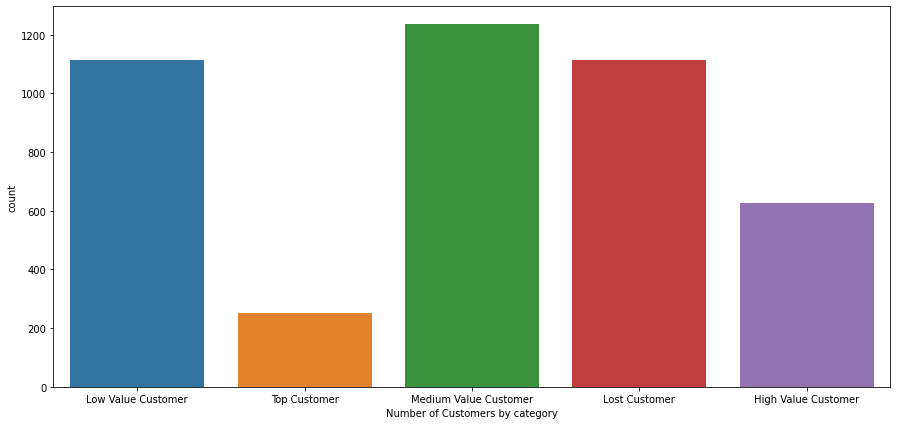

In [110]:
plt.figure(figsize=(15,7))
sns.countplot(rfm['Segment'])
plt.xlabel("Number of Customers by category")
plt.show()